In [1]:
#seurat cell type annotation, zheng68k
#https://satijalab.org/seurat/articles/integration_mapping.html

#split data to 4:1

data=read.table("data/zheng68k/zheng68k.csv",sep=",",header=T,row.names=1)



In [3]:
annotation=read.table("data/zheng68k/68k_pbmc_barcodes_annotation.tsv.txt",header=TRUE,sep="\t")

head(annotation)


,TSNE.1,TSNE.2,barcodes,celltype
,<dbl>,<dbl>,<chr>,<chr>
1,7.565540,0.4413703,AAACATACACCCAA-1,CD8+ Cytotoxic T
2,2.552626,-25.7866723,AAACATACCCCTCA-1,CD8+/CD45RA+ Naive Cytotoxic
3,-5.771831,11.8308460,AAACATACCGGAGA-1,CD4+/CD45RO+ Memory
4,1.762556,25.9793459,AAACATACTAACCG-1,CD19+ B
5,-16.793856,-16.5899699,AAACATACTCTTCA-1,CD4+/CD25 T Reg
6,-15.339791,-11.0882635,AAACATACTGGATC-1,CD4+/CD25 T Reg


In [4]:
data=data[1:10000,]
annotation=annotation[1:10000,]

In [4]:
extract_prediction_label = function(x){
    y=c()
    for (i in x){
        y=c(y,i)
    }
    y
    return(y)
}



calculate_test_accuracy <- function(true_labels, predicted_labels) {
  if (length(true_labels) != length(predicted_labels)) {
    stop("Input vectors must have the same length.")
  }
  
  correct_predictions <- sum(true_labels == predicted_labels)
  total_samples <- length(true_labels)
  
  accuracy <- correct_predictions / total_samples
  return(accuracy)
}


calculate_f1_score_multiclass <- function(true_labels, predicted_labels) {
  if (length(true_labels) != length(predicted_labels)) {
    stop("Input vectors must have the same length.")
  }
  
  # Get unique class labels
  classes <- unique(c(true_labels, predicted_labels))
  
  # Initialize variables to store per-class statistics
  precision <- numeric(length(classes))
  recall <- numeric(length(classes))
  f1_score <- numeric(length(classes))
  
  # Calculate precision, recall, and F1 score for each class
  for (i in 1:length(classes)) {
    class_label <- classes[i]
    true_positive <- sum(predicted_labels == class_label & true_labels == class_label)
    false_positive <- sum(predicted_labels == class_label & true_labels != class_label)
    false_negative <- sum(predicted_labels != class_label & true_labels == class_label)
    
    precision[i] <- true_positive / (true_positive + false_positive)
    recall[i] <- true_positive / (true_positive + false_negative)
    
    f1_score[i] <- 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
  }
  
  # Calculate macro-averaged F1 score
  macro_f1_score <- mean(f1_score, na.rm = TRUE)
  
  return(macro_f1_score)
}




In [5]:
library(Seurat)

set.seed(124)


num_folds <- 5

# Generate 5-fold cross-validation indices
fold_indices <- split(sample(nrow(data)), 1:num_folds)

# Perform 5-fold cross-validation
for (i in 1:num_folds) {
  # Get indices for the current fold
  test_indices <- fold_indices[[i]]
  train_indices <- unlist(fold_indices[-i])
  
  # Subset data and annotation based on indices
  data_train <- data[train_indices, ]
  anno_train <- annotation[train_indices, ]
  
  data_test <- data[test_indices, ]
  anno_test <- annotation[test_indices, ]
  
    
  ref = CreateSeuratObject(counts = t(data_train))
  ref <- ScaleData(ref, verbose = FALSE)
  ref =  FindVariableFeatures(ref, selection.method = "vst", nfeatures = 2000, verbose = FALSE)
  ref <- RunPCA(ref, npcs = 30, verbose = FALSE)
  ref <- RunUMAP(ref, reduction = "pca", dims = 1:30, verbose = FALSE)

  query = CreateSeuratObject(counts = t(data_test))
  query <- ScaleData(query, verbose = FALSE)
  query =  FindVariableFeatures(query, selection.method = "vst", nfeatures = 2000, verbose = FALSE)
  query <- RunPCA(query, npcs = 30, verbose = FALSE)
  query <- RunUMAP(query, reduction = "pca", dims = 1:30, verbose = FALSE)

  ref$celltype=anno_train$celltype
  query$celltype=anno_test$celltype


  ref.anchors <- FindTransferAnchors(reference = ref, query = query, dims = 1:30, reference.reduction = "pca")
  predictions <- TransferData(anchorset = ref.anchors, refdata = ref$celltype,
      dims = 1:30)
  query <- AddMetaData(query, metadata = predictions)
  
  predictions = query$predicted.id



  acc=calculate_test_accuracy(anno_test$celltype,predictions)


  f1_score = calculate_f1_score_multiclass(anno_test$celltype,predictions)


  cat("Fold", i, ": Train samples =", nrow(data_train), ", Test samples =", nrow(data_test), "Accuracy:", acc,"f1 score:",f1_score, "\n")

  
  # Perform training and testing using data_train, anno_train, data_test, and anno_test
}


Attaching SeuratObject

Warning message in split.default(sample(nrow(data)), 1:num_folds):
“data length is not a multiple of split variable”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 39279 anchors

Filtering anchors

	Retained 9339 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



Fold 1 : Train samples = 54863 , Test samples = 13716 Accuracy: 0.6560951 f1 score: 0.657397 


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 39542 anchors

Filtering anchors

	Retained 9593 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



Fold 2 : Train samples = 54863 , Test samples = 13716 Accuracy: 0.6508457 f1 score: 0.5947865 


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 39278 anchors

Filtering anchors

	Retained 9504 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



Fold 3 : Train samples = 54863 , Test samples = 13716 Accuracy: 0.6546369 f1 score: 0.66632 


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 39545 anchors

Filtering anchors

	Retained 9361 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



Fold 4 : Train samples = 54863 , Test samples = 13716 Accuracy: 0.664844 f1 score: 0.5986189 


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 39549 anchors

Filtering anchors

	Retained 9502 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



Fold 5 : Train samples = 54864 , Test samples = 13715 Accuracy: 0.6623405 f1 score: 0.598051 


In [27]:
set.seed(123)
train <- sample(1:nrow(data), 0.999*nrow(data))
test <- setdiff(1:nrow(data), train)

#train
data_train <- data[train,]
anno_train <- annotation[train,]

#test
data_test <- data[test,]
anno_test <- annotation[test,]

In [28]:
library(Seurat)
 
ref = CreateSeuratObject(counts = t(data_train))

ref <- ScaleData(ref, verbose = FALSE)
ref =  FindVariableFeatures(ref, selection.method = "vst", nfeatures = 2000, verbose = FALSE)

ref <- RunPCA(ref, npcs = 30, verbose = FALSE)
ref <- RunUMAP(ref, reduction = "pca", dims = 1:30, verbose = FALSE)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [30]:
query = CreateSeuratObject(counts = t(data_test))

query <- ScaleData(query, verbose = FALSE)
query =  FindVariableFeatures(query, selection.method = "vst", nfeatures = 2000, verbose = FALSE)

query <- RunPCA(query, npcs = 30, verbose = FALSE)
query <- RunUMAP(query, reduction = "pca", dims = 1:30, verbose = FALSE)


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“at  -1.8561”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“radius  0.00029837”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“all data on boundary of neighborhood. make span bigger”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -1.8561”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.017273”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  1”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 0.090619”
Warning message in simpleLoess(y, x

In [31]:
ref$celltype=anno_train$celltype
query$celltype=anno_test$celltype

In [32]:
ref.anchors <- FindTransferAnchors(reference = ref, query = query, dims = 1:30, reference.reduction = "pca")
predictions <- TransferData(anchorset = ref.anchors, refdata = ref$celltype,
    dims = 1:30)
query <- AddMetaData(query, metadata = predictions)

Warning message:
“k.filter is larger than the number of cells present in the query.
Continuing without anchor filtering.”


Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 345 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [37]:
a=1
query$prediction.match <- query$predicted.id == query$celltype
print(table(query$prediction.match))
a


FALSE  TRUE 
   28    41 


[1] 1

In [40]:
library(Seurat)
set.seed(123)

# Number of folds
num_folds <- 100

# Generate 5-fold cross-validation indices
fold_indices <- split(sample(nrow(data)), 1:num_folds)

# Perform 5-fold cross-validation
for (i in 1:num_folds) {
  # Get indices for the current fold
  test_indices <- fold_indices[[i]]
  train_indices <- unlist(fold_indices[-i])
  
  # Subset data and annotation based on indices
  data_train <- data[train_indices, ]
  anno_train <- annotation[train_indices, ]
  
  data_test <- data[test_indices, ]
  anno_test <- annotation[test_indices, ]
  
  
  ref = CreateSeuratObject(counts = t(data_train))
  ref <- ScaleData(ref, verbose = FALSE)
  ref =  FindVariableFeatures(ref, selection.method = "vst", nfeatures = 2000, verbose = FALSE)
  ref <- RunPCA(ref, npcs = 30, verbose = FALSE)
  ref <- RunUMAP(ref, reduction = "pca", dims = 1:30, verbose = FALSE)

  query = CreateSeuratObject(counts = t(data_test))
  query <- ScaleData(query, verbose = FALSE)
  query =  FindVariableFeatures(query, selection.method = "vst", nfeatures = 2000, verbose = FALSE)
  query <- RunPCA(query, npcs = 30, verbose = FALSE)
  query <- RunUMAP(query, reduction = "pca", dims = 1:30, verbose = FALSE)
  
  ref$celltype=anno_train$celltype
  query$celltype=anno_test$celltype

  ref.anchors <- FindTransferAnchors(reference = ref, query = query, dims = 1:30, reference.reduction = "pca")
  predictions <- TransferData(anchorset = ref.anchors, refdata = ref$celltype,dims = 1:30)
  query <- AddMetaData(query, metadata = predictions)

  query$prediction.match <- query$predicted.id == query$celltype
  print(table(query$prediction.match))

  cat("Fold", i, ": Train samples =", nrow(data_train), ", Test samples =", nrow(data_test), "\n")

  
  # Perform training and testing using data_train, anno_train, data_test, and anno_test
}


Warning message in split.default(sample(nrow(data)), 1:num_folds):
“data length is not a multiple of split variable”


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.8585”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.49932”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  5.704e-16”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 0.090619”
Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 3289 anchors

Filtering anchors

	Retained 2583 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels




FALSE  TRUE 
  219   467 
Fold 1 : Train samples = 67893 , Test samples = 686 


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.8585”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.49931”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  4.7026e-16”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 0.090619”
Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 3313 anchors

Filtering anchors

	Retained 2649 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels




FALSE  TRUE 
  238   448 
Fold 2 : Train samples = 67893 , Test samples = 686 


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.5353”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  2.567e-16”
Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 3297 anchors

Filtering anchors

	Retained 2591 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels




FALSE  TRUE 
  251   435 
Fold 3 : Train samples = 67893 , Test samples = 686 


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.5353”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  1.4552e-16”
Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 3323 anchors

Filtering anchors

	Retained 2649 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels




FALSE  TRUE 
  233   453 
Fold 4 : Train samples = 67893 , Test samples = 686 


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.8585”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.4993”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  7.2207e-16”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 0.090619”
Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 3278 anchors

Filtering anchors

	Retained 2562 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels




FALSE  TRUE 
  247   439 
Fold 5 : Train samples = 67893 , Test samples = 686 


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.8585”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.49934”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  5.7692e-16”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 0.090619”
Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 3329 anchors

Filtering anchors



In [26]:
query$prediction.match

ERROR: Error: Cannot find 'prediction.match' in this Seurat object


In [5]:
library(Seurat)
library(SeuratData)



── Installed datasets ───────────────────────────────────── SeuratData v0.2.2 ──

✔ ifnb         3.1.0                    ✔ pbmc3k       3.1.4
✔ panc8        3.0.2                    ✔ pbmcMultiome 0.1.4


────────────────────────────────────── Key ─────────────────────────────────────

✔ Dataset loaded successfully
❯ Dataset built with a newer version of Seurat than installed
❓ Unknown version of Seurat installed




In [41]:
data("pbmc3k")

In [47]:
pbmc3k = NormalizeData(pbmc3k,verbose=FALSE)

pbmc3k = FindVariableFeatures(pbmc3k, selection.method = "vst", nfeatures = 2000,        verbose = FALSE)

In [6]:
data("panc8")
pancreas.list <- SplitObject(panc8, split.by = "tech")
pancreas.list <- pancreas.list[c("celseq", "celseq2", "fluidigmc1", "smartseq2")]

In [7]:
for (i in 1:length(pancreas.list)) {
    pancreas.list[[i]] <- NormalizeData(pancreas.list[[i]], verbose = FALSE)
    pancreas.list[[i]] <- FindVariableFeatures(pancreas.list[[i]], selection.method = "vst", nfeatures = 2000,
        verbose = FALSE)
}

In [9]:
reference.list <- pancreas.list[c("celseq", "celseq2", "smartseq2")]
pancreas.anchors <- FindIntegrationAnchors(object.list = reference.list, dims = 1:30)

Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3514 anchors

Filtering anchors

	Retained 2753 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3499 anchors

Filtering anchors

	Retained 2718 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6174 anchors

Filtering anchors

	Retained 4540 anchors



In [10]:
pancreas.integrated <- IntegrateData(anchorset = pancreas.anchors, dims = 1:30)

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 3 into 2 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data




Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


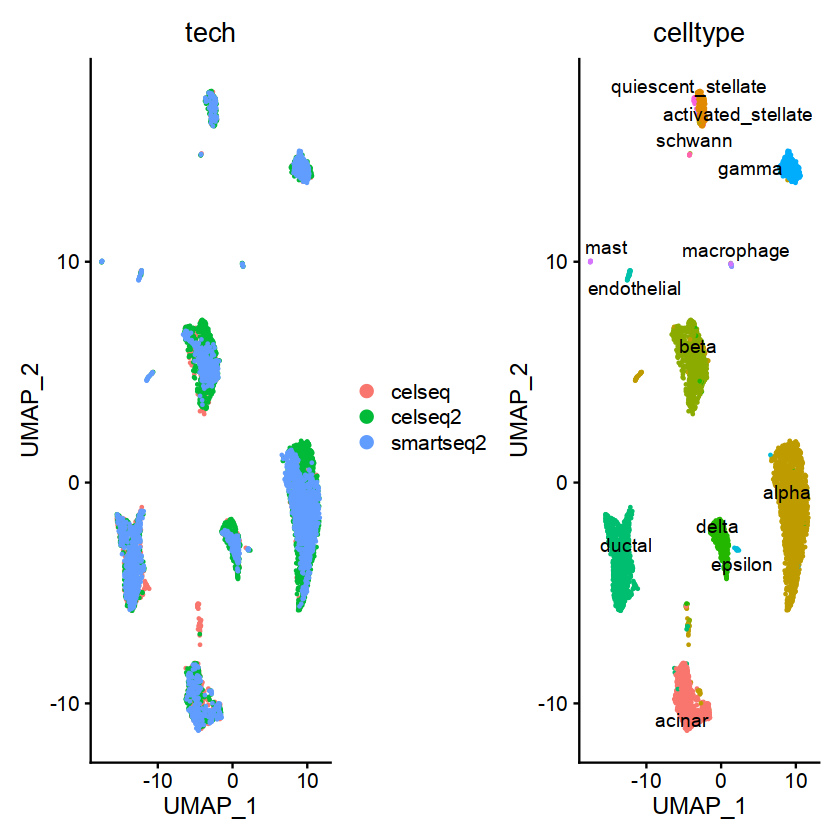

In [11]:
library(ggplot2)
library(cowplot)
library(patchwork)
# switch to integrated assay. The variable features of this assay are automatically set during
# IntegrateData
DefaultAssay(pancreas.integrated) <- "integrated"
# Run the standard workflow for visualization and clustering
pancreas.integrated <- ScaleData(pancreas.integrated, verbose = FALSE)
pancreas.integrated <- RunPCA(pancreas.integrated, npcs = 30, verbose = FALSE)
pancreas.integrated <- RunUMAP(pancreas.integrated, reduction = "pca", dims = 1:30, verbose = FALSE)
p1 <- DimPlot(pancreas.integrated, reduction = "umap", group.by = "tech")
p2 <- DimPlot(pancreas.integrated, reduction = "umap", group.by = "celltype", label = TRUE, repel = TRUE) +
    NoLegend()
p1 + p2

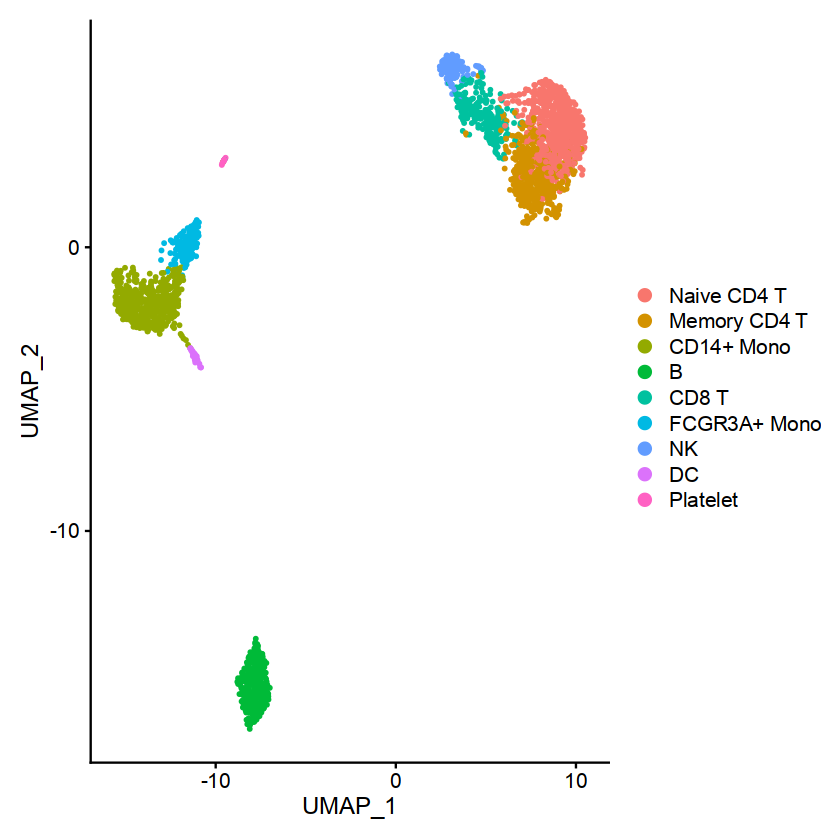

In [59]:
library(ggplot2)
library(cowplot)
library(patchwork)
# switch to integrated assay. The variable features of this assay are automatically set during
# IntegrateData
#DefaultAssay(pbmc3k) <- "RNA"
# Run the standard workflow for visualization and clustering
pbmc3k <- ScaleData(pbmc3k.final, verbose = FALSE)
pbmc3k <- RunPCA(pbmc3k, npcs = 30, verbose = FALSE)
pbmc3k <- RunUMAP(pbmc3k, reduction = "pca", dims = 1:30, verbose = FALSE)
p1 <- DimPlot(pbmc3k, reduction = "umap")
p2 <- DimPlot(pbmc3k, reduction = "umap") +
    NoLegend()
p1 

In [64]:
pbmc3k
pancreas.query <- data
pancreas.anchors <- FindTransferAnchors(reference = pbmc3k, query = pancreas.query,
    dims = 1:30, reference.reduction = "pca")
predictions <- TransferData(anchorset = pancreas.anchors, refdata = pbmc3k$seurat_annotations,
    dims = 1:30)
pancreas.query <- AddMetaData(pancreas.query, metadata = predictions)

An object of class Seurat 
13714 features across 2638 samples within 1 assay 
Active assay: RNA (13714 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 2541 anchors

Filtering anchors

	Retained 263 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [12]:
pancreas.query <- data
pancreas.anchors <- FindTransferAnchors(reference = pancreas.integrated, query = pancreas.query,
    dims = 1:30, reference.reduction = "pca")
predictions <- TransferData(anchorset = pancreas.anchors, refdata = pancreas.integrated$celltype,
    dims = 1:30)
pancreas.query <- AddMetaData(pancreas.query, metadata = predictions)

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 919 anchors

Filtering anchors

	Retained 842 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [68]:
str(pancreas.query)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ counts       :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:37323295] 53 70 81 166 178 229 316 383 415 492 ...
  .. .. .. .. .. ..@ p       : int [1:68580] 0 498 970 1512 1861 2307 2783 3305 4230 4719 ...
  .. .. .. .. .. ..@ Dim     : int [1:2] 32738 68579
  .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. ..$ : chr [1:32738] "MIR1302.10" "FAM138A" "OR4F5" "RP11.34P13.7" ...
  .. .. .. .. .. .. ..$ : chr [1:68579] "AAACATACACCCAA-1" "AAACATACCCCTCA-1" "AAACATACCGGAGA-1" "AAACATACTAACCG-1" ...
  .. .. .. .. .. ..@ x       : num [1:37323295] 1 1 1 1 3 1 1 1 1 10 ...
  .. .. .. .. .. ..@ factors : list()
  .. .. .. ..@ data         :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:37323295] 53 70 81 166 178 229 

In [65]:
pancreas.query$prediction.match <- pancreas.query$predicted.id == pancreas.query$celltype
table(pancreas.query$prediction.match)

ERROR: Error: Cannot find 'celltype' in this Seurat object


In [14]:
table(pancreas.query$predicted.id)


            acinar activated_stellate              alpha               beta 
                22                 17                253                256 
             delta             ductal        endothelial              gamma 
                22                 30                 12                 18 
        macrophage               mast            schwann 
                 1                  2                  5 

Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”


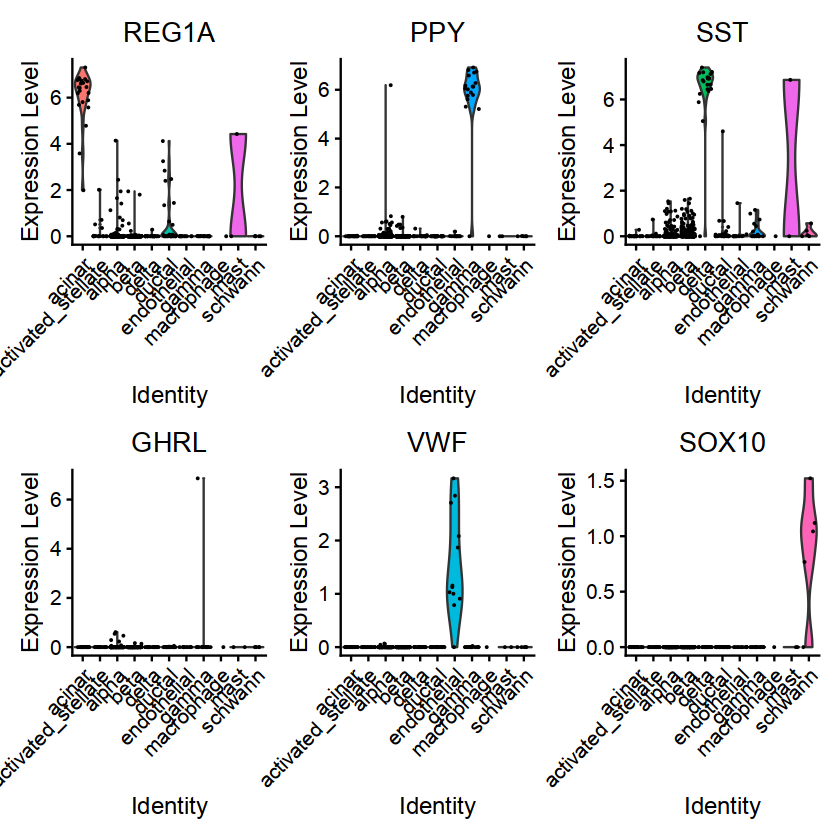

In [15]:
VlnPlot(pancreas.query, c("REG1A", "PPY", "SST", "GHRL", "VWF", "SOX10"), group.by = "predicted.id")

In [6]:
#singleR

library(scRNAseq)
sce <- GrunHSCData(ensembl=TRUE)
sce


snapshotDate(): 2022-10-31

see ?scRNAseq and browseVignettes('scRNAseq') for documentation

loading from cache

snapshotDate(): 2022-10-31

loading from cache

require("ensembldb")

Warning message:
"Unable to map 1655 of 23536 requested IDs."


class: SingleCellExperiment 
dim: 21817 1915 
metadata(0):
assays(1): counts
rownames(21817): ENSMUSG00000109644 ENSMUSG00000007777 ...
  ENSMUSG00000055670 ENSMUSG00000039068
rowData names(3): symbol chr originalName
colnames(1915): JC4_349_HSC_FE_S13_ JC4_350_HSC_FE_S13_ ...
  JC48P6_1203_HSC_FE_S8_ JC48P6_1204_HSC_FE_S8_
colData names(2): sample protocol
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [7]:
sce$counts

NULL

In [8]:
str(sce)

Formal class 'SingleCellExperiment' [package "SingleCellExperiment"] with 9 slots
  ..@ int_elementMetadata:Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  .. .. ..@ rownames       : NULL
  .. .. ..@ nrows          : int 21817
  .. .. ..@ elementType    : chr "ANY"
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       : list()
  .. .. ..@ listData       :List of 1
  .. .. .. ..$ rowPairs:Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  .. .. .. .. .. ..@ rownames       : NULL
  .. .. .. .. .. ..@ nrows          : int 21817
  .. .. .. .. .. ..@ elementType    : chr "ANY"
  .. .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. .. ..@ metadata       : list()
  .. .. .. .. .. ..@ listData       : Named list()
  ..@ int_colData        :Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  .. .. ..@ rownames       : NULL
  .. .. ..@ nrows          : int 1915
  .. .. ..@ elementType    : chr "ANY"
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       :

In [9]:
library(celldex)
immgen <- ImmGenData(ensembl=TRUE)
immgen


Attaching package: 'celldex'


The following objects are masked from 'package:SingleR':

    BlueprintEncodeData, DatabaseImmuneCellExpressionData,
    HumanPrimaryCellAtlasData, ImmGenData, MonacoImmuneData,
    MouseRNAseqData, NovershternHematopoieticData




snapshotDate(): 2022-10-31

see ?celldex and browseVignettes('celldex') for documentation

loading from cache

see ?celldex and browseVignettes('celldex') for documentation

loading from cache

snapshotDate(): 2022-10-31

loading from cache

Warning message:
"Unable to map 782 of 22134 requested IDs."


class: SummarizedExperiment 
dim: 21352 830 
metadata(0):
assays(1): logcounts
rownames(21352): ENSMUSG00000079681 ENSMUSG00000066372 ...
  ENSMUSG00000034640 ENSMUSG00000036940
rowData names(0):
colnames(830):
  GSM1136119_EA07068_260297_MOGENE-1_0-ST-V1_MF.11C-11B+.LU_1.CEL
  GSM1136120_EA07068_260298_MOGENE-1_0-ST-V1_MF.11C-11B+.LU_2.CEL ...
  GSM920654_EA07068_201214_MOGENE-1_0-ST-V1_TGD.VG4+24ALO.E17.TH_1.CEL
  GSM920655_EA07068_201215_MOGENE-1_0-ST-V1_TGD.VG4+24ALO.E17.TH_2.CEL
colData names(3): label.main label.fine label.ont